In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

from nltk.corpus import stopwords
import pickle

from tqdm import tqdm
import os

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'14OVXWu_SJU-lJD-jKMOCld14EZ21lYYe'}) # replace the id with id of file you want to access
downloaded.GetContentFile('resources.csv')
downloaded1 = drive.CreateFile({'id':'1T48h84GLW3dpy9F6ble5nF_1gQxBO8rx'}) # replace the id with id of file you want to access
downloaded1.GetContentFile('train_data.csv')

In [0]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [7]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

print(project_data['project_is_approved'].value_counts())

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']
1    92706
0    16542
Name: project_is_approved, dtype: int64


In [8]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [9]:
project_data.head(5)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Math & Science,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1


In [10]:
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' The ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace('&','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(',','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.lower()
len(project_data['project_subject_subcategories'].value_counts())

401

In [11]:
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' The ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace('&','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(',','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.lower()
len(project_data['project_subject_categories'].value_counts())

51

In [18]:
print(project_data["project_is_approved"].value_counts())

project_data.index=np.arange(0,len(project_data))
non_approved=[]
approved=[]

for i in range(len(project_data)):
    if(project_data.loc[i,"project_is_approved"]==0):
        non_approved.append(project_data.loc[i])
    else:
        approved.append(project_data.loc[i]) 
# Number of observations in each class
non_approved
print(len(non_approved))
print(len(approved))

1    92706
0    16542
Name: project_is_approved, dtype: int64
16542
92706


In [0]:
import random 
length=len(approved)-len(non_approved)
for i in range(length):
    k=random.randrange(0,16542)
    non_approved.append(project_data.loc[k])


In [0]:
#approved.head(3)
non_approved=pd.concat(non_approved,axis=1)
approved=pd.concat(approved,axis=1)
approved=approved.T
non_approved=non_approved.T

In [0]:
project_data_new=pd.concat([non_approved,approved])

In [0]:
project_data_new=project_data_new.sort_values(by='project_submitted_datetime')

In [0]:
project_data=project_data_new

### preprocessing of project_subject_subcategories

In [0]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [14]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [15]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.     The materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   They also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. Phys

In [16]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations The materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills They also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is the

In [17]:
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()
project_data['project_grade_category'].value_counts()

grades_prek_2    44225
grades_3_5       37137
grades_6_8       16923
grades_9_12      10963
Name: project_grade_category, dtype: int64

In [18]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()
project_data['teacher_prefix'].value_counts()

mrs        57269
ms         38955
mr         10648
teacher     2360
dr            13
Name: teacher_prefix, dtype: int64

In [19]:
project_data['school_state'] = project_data['school_state'].str.lower()
len(project_data['school_state'].value_counts())

51

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [21]:
from sklearn import model_selection
#x_bow=x_bow.tocsr()

y=project_data['project_is_approved']
X_1, X_test, y_1, y_test = model_selection.train_test_split(project_data, y, test_size=0.33, random_state=0,
                                                            stratify = project_data['project_is_approved'])
X_tr, X_cv, y_tr, y_cv = model_selection.train_test_split(X_1, y_1, test_size=0.33)
print(X_tr.shape, y_tr.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)
print("="*100)

(49041, 18) (49041,)
(24155, 18) (24155,)
(36052, 18) (36052,)


In [0]:
X_test.drop(['project_is_approved'],axis=1,inplace=True)
X_tr.drop(['project_is_approved'],axis=1,inplace=True)

In [0]:
X_cv.drop(['project_is_approved'],axis=1,inplace=True)

In [24]:
from tqdm import tqdm
tr_essay = []
# tqdm is for printing the status bar
for sentence in tqdm(X_tr['essay'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    tr_essay.append(sent.lower().strip())

100%|██████████| 49041/49041 [00:30<00:00, 1628.12it/s]


In [25]:
cv_essay = []
# tqdm is for printing the status bar
for sentence in tqdm(X_cv['essay'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = sent.lower().strip()
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    cv_essay.append(sent.lower().strip())

100%|██████████| 24155/24155 [00:14<00:00, 1676.21it/s]


In [26]:
test_essay_test = []
# tqdm is for printing the status bar
for sentence in tqdm(X_test['essay'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    test_essay_test.append(sent.lower().strip())

100%|██████████| 36052/36052 [00:21<00:00, 1682.65it/s]


In [0]:
tr_title = []

for titles in tqdm(X_tr["project_title"]):
    title = decontracted(titles)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = title.replace('\\n', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    title = ' '.join(f for f in title.split() if f not in stopwords)
    tr_title.append(title.lower().strip())

100%|██████████| 49041/49041 [00:01<00:00, 39437.75it/s]


In [0]:

test_title_test = []

for titles in tqdm(X_test["project_title"]):
    title = decontracted(titles)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = title.replace('\\n', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    title = ' '.join(f for f in title.split() if f not in stopwords)
    test_title_test.append(title.lower().strip())

100%|██████████| 36052/36052 [00:00<00:00, 39410.98it/s]


### Vectorizing categorical Data

In [0]:
X_tr['teacher_prefix']=X_tr['teacher_prefix'].fillna('mrs')
X_test['teacher_prefix']=X_test['teacher_prefix'].fillna('mrs')
X_cv['teacher_prefix']=X_cv['teacher_prefix'].fillna('mrs')

In [0]:
# https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
from sklearn.preprocessing import LabelEncoder
import numpy as np


class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [0]:
# we use count vectorizer to convert the values into one 

vectorizer = LabelEncoderExt()
vectorizer=vectorizer.fit(X_tr['project_subject_categories'].values)
categories_one_hot_tr = vectorizer.transform(X_tr['project_subject_categories'].values)
categories_one_hot_cv = vectorizer.transform(X_cv['project_subject_categories'].values)

categories_one_hot_test = vectorizer.transform(X_test['project_subject_categories'].values)

In [0]:
vectorizer = LabelEncoderExt()
vectorizer=vectorizer.fit(X_tr['project_subject_subcategories'].values)
sub_categories_one_hot_tr = vectorizer.transform(X_tr['project_subject_subcategories'].values)
sub_categories_one_hot_cv = vectorizer.transform(X_cv['project_subject_subcategories'].values)
sub_categories_one_hot_test = vectorizer.transform(X_test['project_subject_subcategories'].values)

In [0]:
vectorizer =LabelEncoder()
vectorizer.fit(X_tr['school_state'].values)
state_one_hot_tr=vectorizer.transform(X_tr['school_state'].values)
state_one_hot_cv=vectorizer.transform(X_cv['school_state'].values)
state_one_hot_test=vectorizer.transform(X_test['school_state'].values)


In [0]:
vectorizer =LabelEncoder()
vectorizer.fit(X_tr['project_grade_category'].values)
project_grade_category_tr=vectorizer.transform(X_tr['project_grade_category'].values)
project_grade_category_cv=vectorizer.transform(X_cv['project_grade_category'].values)
project_grade_category_test=vectorizer.transform(X_test['project_grade_category'].values)


In [0]:
vectorizer = LabelEncoder()
vectorizer.fit(X_tr['teacher_prefix'].values)
teacher_prefix_tr=vectorizer.transform(X_tr['teacher_prefix'].values)
teacher_prefix_cv=vectorizer.transform(X_cv['teacher_prefix'].values)
teacher_prefix_test=vectorizer.transform(X_test['teacher_prefix'].values)

In [32]:
len(teacher_prefix_tr)

49041

### Embedding categorical Data

In [34]:
from tensorflow.keras.preprocessing import sequence

In [0]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Input , Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import concatenate

In [36]:
unique_cat  = X_tr["project_subject_subcategories"].nunique()
embsize_cat = int(min(np.ceil((unique_cat)/2), 50 ))
sub_categories = Input(shape=(1,))
embedding = Embedding(401, embsize_cat, input_length=1)(sub_categories)
flatten_project_subject_subcategories = Flatten()(embedding)


unique_prefix  = X_tr["teacher_prefix"].nunique()
embsize_prefix = int(min(np.ceil((unique_prefix)/2), 50 ))
teacher_prefix = Input(shape=(1,))
embedding = Embedding(5, embsize_prefix, input_length=1)(teacher_prefix)
flatten_teacher_prefix = Flatten()(embedding)

unique_category  = X_tr["project_subject_categories"].nunique()
embsize_category = int(min(np.ceil((unique_category)/2), 50 ))
categories = Input(shape=(1,))
embedding = Embedding(51, embsize_category, input_length=1)(categories)
flatten_categories = Flatten()(embedding)

unique_state  = X_tr["school_state"].nunique()
embsize_state = int(min(np.ceil((unique_state)/2), 50 ))
school_state = Input(shape=(1,))
embedding = Embedding(51, embsize_state, input_length=1)(school_state)
flatten_school_state = Flatten()(embedding)

unique_grade  = X_tr["project_grade_category"].nunique()
embsize_grade = int(min(np.ceil((unique_grade)/2), 50 ))
project_grade_category = Input(shape=(1,))
embedding = Embedding(4, embsize_grade, input_length=1)(project_grade_category)
flatten_project_grade_category = Flatten()(embedding)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [37]:
flatten_project_grade_category.shape

TensorShape([Dimension(None), Dimension(2)])

In [0]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

model = Sequential()
model.add(Embedding(401, 2, input_length=1))
output_array_sub_categories_one_hot_tr = model.predict(sub_categories_one_hot_tr)
output_array_sub_categories_one_hot_cv = model.predict(sub_categories_one_hot_cv)
output_array_sub_categories_one_hot_test = model.predict(sub_categories_one_hot_test)

### Numerical Features

In [39]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
#project_data = pd.merge(project_data, price_data, on='id', how='left')
X_tr=pd.merge(X_tr,price_data,on='id',how='left')
X_cv=pd.merge(X_cv,price_data,on='id',how='left')
X_test=pd.merge(X_test,price_data,on='id',how='left')
X_tr.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,essay,price,quantity
0,102811,p048940,2cb874bd7f62f9d15ae9208888ba9b2d,mrs,ar,2016-11-09 11:32:54,grades_3_5,literacy_language_math_science,literature_writing_mathematics,Wobble Baby Wobble Baby,I work at a neighborhood school with a wide va...,Students have to move! Students these days are...,NaN,NaN,"My students need wobble chairs, wobble cushion...",3,I work at a neighborhood school with a wide va...,137.69,12
1,138157,p121677,028156225cf81c84e00596df96bc1e21,ms,ga,2016-10-26 13:27:22,grades_prek_2,literacy_language,literature_writing,Enough for everyone!,"My classroom is filled with eager, smiling and...",The pencil sharpener will be used daily and wi...,NaN,NaN,My students need headphones that work for each...,0,"My classroom is filled with eager, smiling and...",92.66,9
2,16638,p145755,1e38f311579fd51da5bd78ce013447aa,mrs,az,2017-03-30 11:42:09,grades_prek_2,math_science,appliedsciences_mathematics,STEM / STEAM Bristle Bot Robots,Do you remember when school was so confusing? ...,Can you picture small groups of children scatt...,NaN,NaN,My students need Bristle Bots because are the ...,6,Do you remember when school was so confusing? ...,38.46,17


In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_tr['price'].values.reshape(-1, 1))
price_normalized_tr=scaler.transform(X_tr['price'].values.reshape(-1, 1) )
price_normalized_cv=scaler.transform(X_cv['price'].values.reshape(-1, 1) )
price_normalized_test=scaler.transform(X_test['price'].values.reshape(-1, 1) )

In [41]:
price_normalized_tr

array([[-0.44509677],
       [-0.57035222],
       [-0.72111494],
       ...,
       [ 0.23837016],
       [ 0.15019344],
       [-0.76058584]])

In [0]:
scaler = StandardScaler()
scaler.fit(X_tr['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
teacher_prv_postprjct_normalise_tr=scaler.transform(X_tr['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1) )
teacher_prv_postprjct_normalise_cv=scaler.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1) )
teacher_prv_postprjct_normalise_test=scaler.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1) )

In [43]:
teacher_prv_postprjct_normalise_tr

array([[-0.29479258],
       [-0.40352095],
       [-0.18606421],
       ...,
       [-0.40352095],
       [-0.14982142],
       [-0.33103537]])

In [0]:
scaler = StandardScaler()
scaler.fit(X_tr['quantity'].values.reshape(-1, 1))
quantity_normalised_tr=scaler.transform(X_tr['quantity'].values.reshape(-1, 1) )
quantity_normalised_cv=scaler.transform(X_cv['quantity'].values.reshape(-1, 1) )
quantity_normalised_test=scaler.transform(X_test['quantity'].values.reshape(-1, 1) )

In [45]:
print(price_normalized_tr.shape)
print(price_normalized_test.shape)

print(teacher_prv_postprjct_normalise_test.shape)
print(teacher_prv_postprjct_normalise_tr.shape)

print(quantity_normalised_tr.T.shape)
print(quantity_normalised_test.shape)

(49041, 1)
(36052, 1)
(36052, 1)
(49041, 1)
(1, 49041)
(36052, 1)


In [0]:
numerical_tr=np.hstack((price_normalized_tr,teacher_prv_postprjct_normalise_tr,quantity_normalised_tr))
numerical_cv=np.hstack((price_normalized_cv,teacher_prv_postprjct_normalise_cv,quantity_normalised_cv))
numerical_test=np.hstack((price_normalized_test,teacher_prv_postprjct_normalise_test,quantity_normalised_test))

In [47]:
numerical_test.shape

(36052, 3)

In [0]:
Input_model = Input(shape=(3,),name="numerical_data")

# layer 1
layer_1 = Dense(units=1,activation='relu',kernel_initializer='he_normal',name="layer_1")(Input_model)

In [62]:
layer_1

<tf.Tensor 'layer_1/Relu:0' shape=(?, 1) dtype=float32>

### Text Data

In [49]:
from google.colab import drive

drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [64]:
from numpy import array
from numpy import asarray
from numpy import zeros
embeddings_index = dict()
f = open('/content/drive/My Drive/glove.6B.200d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [0]:
def padded(encoded_docs):  
    max_length = 350
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    return padded_docs

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(tr_essay)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs_tr = t.texts_to_sequences(tr_essay)
essay_padded_tr = padded(encoded_docs_tr)

In [0]:
encoded_docs_cv = t.texts_to_sequences(cv_essay)
essay_padded_cv = padded(encoded_docs_cv)

In [394]:
print(essay_padded_cv[0])

[ 281   65   31    4 1310 2018  901  495   67   69 2234    1    6   90
    1   37  432   16 1585  337   39   34  323  693 3430 3434  313    1
   17    2   37  432   16   84    6  216 1773 1020    1  947  151  213
  181    2  678  886   17  700  262  309 3422  156 2749  570   11 1773
   37   16   39    1  156   76   10  419  202 1544  523  606   90    1
  462    4 3712   34 1713 1096  109    2   24 1688   39    1  210   34
   76 1372  205  292   32  190  293  154   34   26 3480  365    1    3
   39   76   10 1026  127  132  313  281    4  465 2935 1643  814   12
  172   39  206  981  154    1  702  137   14   12  190  722  162 3158
  178  293 2732    1 2206   34   96  310    3  281    4   34 1096  252
  981 2206 2044    3   73    9    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [0]:
encoded_docs_test = t.texts_to_sequences(test_essay_test)
essay_padded_test = padded(encoded_docs_test)

In [459]:
print(essay_padded_test[0])

[   1   84    6   14   99  647  373  160    2 2379   80  123   30 1451
  318  126  319   46    3   74  232    1  160  355   15 8716   99  205
  167    3  172    5    6   48   41 2027   41   48    6  399   23 1158
    1   32  355  168 3456  141 2145  205  186   46   11  272   61  409
 2283  572  366  986    1 3320  384 4440  986 2554  259 1150   11 1061
  168  183  108    4  186   32  598 1637  256  110   46   27   63    1
  267  708    4  124   46   11  677  371  974   35  137    1   99   46
   11  310  162   22  445  107  102  267  272    4    9    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [460]:
print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 200))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.


In [398]:
print(vocab_size)

41213


In [0]:
from tensorflow.keras.layers import LSTM
text = Input(shape=(350,))
embedding = Embedding(vocab_size, 200, input_length=350,weights=[embedding_matrix])(text)
embedding1=LSTM(128,recurrent_dropout=0.5,return_sequences=True)(embedding)
flatten_text = Flatten()(embedding1)

In [462]:
flatten_text

<tf.Tensor 'flatten_51/Reshape:0' shape=(?, 44800) dtype=float32>

### concatenation

In [0]:
from tensorflow.keras.layers import concatenate
concat_layer=concatenate(inputs=[flatten_categories,flatten_project_grade_category,flatten_school_state,flatten_teacher_prefix,
                                 flatten_project_subject_subcategories,flatten_text,layer_1],name="concat" )

In [347]:
concat_layer

<tf.Tensor 'concat_4/concat:0' shape=(?, 44907) dtype=float32>

In [0]:
from tensorflow.keras.layers import Dense,concatenate,Activation,Dropout,Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from keras.regularizers import l1
from keras.layers import LeakyReLU

In [0]:
normalize=BatchNormalization()(concat_layer)
#layer1 = Dense(units=256,activation='relu',kernel_initializer='glorot_normal',kernel_regularizer=l2(0.001),name="layer1")(normalize)
#layer1 = Dropout(.65)(layer1)
layer2 = Dense(units=64,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(),name="layer2")(normalize)
layer2 = Dropout(.65)(layer2)
normalize=BatchNormalization()(layer2)
layer3 = Dense(units=32,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(),name='layer3')(normalize)
layer3 = Dropout(.55)(layer3)
layer4 = Dense(units=16,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(),name="layer4")(layer3)
layer4 = Dropout(.55)(layer4)
output = Dense(1,activation='sigmoid',name="output")(layer4)

In [0]:
model = Model(inputs=[categories,project_grade_category,school_state,teacher_prefix,sub_categories,text,Input_model],outputs=output)

In [467]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_50 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_52 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_51 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

In [0]:
import tensorflow as tf


In [0]:
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
  try:
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)
  
  except ValueError:
     pass

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=[auroc])

In [0]:
from keras.utils import to_categorical
y_binary_tr= to_categorical(y_tr)
y_binary_cv = to_categorical(y_cv)
y_binary_test = to_categorical(y_test)

In [77]:
np.isnan(y_binary_cv)

array([[False, False],
       [False, False],
       [False, False],
       ...,
       [False, False],
       [False, False],
       [False, False]])

In [471]:
history=model.fit([categories_one_hot_tr,project_grade_category_tr,state_one_hot_tr,teacher_prefix_tr,sub_categories_one_hot_tr,essay_padded_tr,numerical_tr]
          ,y_tr,batch_size=500,epochs=5,
          validation_data=([categories_one_hot_cv,project_grade_category_cv,state_one_hot_cv,teacher_prefix_cv,sub_categories_one_hot_cv,essay_padded_cv,
                            numerical_cv],y_cv))

Train on 83231 samples, validate on 40995 samples
Epoch 1/5
83231/83231 [==============================] - 1430s 17ms/sample - loss: 1.8322 - auroc: 0.5280 - val_loss: 1.1214 - val_auroc: 0.5502
Epoch 2/5
83231/83231 [==============================] - 1434s 17ms/sample - loss: 0.8949 - auroc: 0.5814 - val_loss: 0.7347 - val_auroc: 0.7131
Epoch 3/5
83231/83231 [==============================] - 1403s 17ms/sample - loss: 0.6221 - auroc: 0.6329 - val_loss: 0.5484 - val_auroc: 0.7499
Epoch 4/5
83231/83231 [==============================] - 1380s 17ms/sample - loss: 0.5127 - auroc: 0.6925 - val_loss: 0.4705 - val_auroc: 0.7850
Epoch 5/5
83231/83231 [==============================] - 1341s 16ms/sample - loss: 0.4684 - auroc: 0.7764 - val_loss: 0.4638 - val_auroc: 0.8092


dict_keys(['loss', 'auroc', 'val_loss', 'val_auroc'])


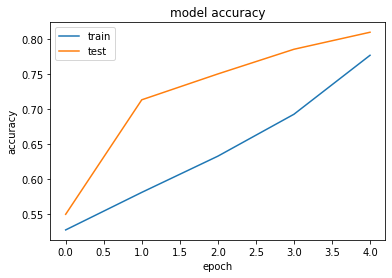

In [472]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['auroc'])
plt.plot(history.history['val_auroc']) 
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [474]:
score = model.evaluate([categories_one_hot_test,project_grade_category_test,state_one_hot_test,
                       teacher_prefix_test,sub_categories_one_hot_test,essay_padded_test,
                            numerical_test],y_test,batch_size=500)

61186/61186 [==============================] - 237s 4ms/sample - loss: 0.4651 - auroc: 0.8026


### Model 2

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf_eassay = TfidfVectorizer(min_df=5,use_idf=True,max_features=12000)
vectorizer_tfidf_eassay = vectorizer_tfidf_eassay.fit(tr_essay)
eassay_tfidf_tr=vectorizer_tfidf_eassay.transform(tr_essay)
print("Shape of matrix after one hot encodig ",eassay_tfidf_tr.shape)
eassay_tfidf_test=vectorizer_tfidf_eassay.transform(test_essay_test)
eassay_tfidf_cv=vectorizer_tfidf_eassay.transform(cv_essay)

print("Shape of matrix after one hot encodig ",eassay_tfidf_test.shape)

Shape of matrix after one hot encodig  (49041, 12000)
Shape of matrix after one hot encodig  (36052, 12000)


In [51]:
vectorizer_tfidf_eassay.idf_.max()

10.00867288358469

In [52]:
vectorizer_tfidf_eassay.idf_[1000]

6.880451426984621

In [0]:
idf=vectorizer_tfidf_eassay.idf_

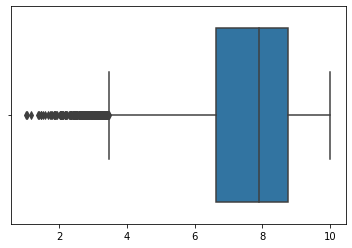

In [54]:
import seaborn as sns

sns.boxplot(idf)

In [0]:
sorted_features = np.argsort(vectorizer_tfidf_eassay.idf_[::-1])
features = vectorizer_tfidf_eassay.get_feature_names()
top_features = [features[i] for i in sorted_features[2500:8000]]

In [0]:
not_imp_words = []
for word in features:
  if word not in top_features:
    not_imp_words.append(word)

In [0]:
sorted_features1=np.sort(vectorizer_tfidf_eassay.idf_)

In [58]:
sorted_features1[8000]

8.504595486808416

In [59]:
my_tr_essay=[]

for sent in tqdm(tr_essay):
  sent = ' '.join(e for e in sent.split() if e not in not_imp_words)
  my_tr_essay.append(sent)

100%|██████████| 49041/49041 [08:23<00:00, 97.49it/s]


In [60]:
my_cv_essay=[]
for sent in tqdm(cv_essay):
  sent = ' '.join(e for e in sent.split() if e not in not_imp_words)
  my_cv_essay.append(sent)

100%|██████████| 24155/24155 [04:14<00:00, 94.78it/s]


In [61]:
my_test_essay=[]

for sent in tqdm(test_essay_test):
  sent = ' '.join(e for e in sent.split() if e not in not_imp_words)
  my_test_essay.append(sent)

100%|██████████| 36052/36052 [06:15<00:00, 95.96it/s]


### padding

In [7]:
from google.colab import drive

drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [99]:
from numpy import array
from numpy import asarray
from numpy import zeros
embeddings_index = dict()
f = open('/content/drive/My Drive/glove.6B.200d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [0]:
def padded(encoded_docs):  
    max_length =300
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    return padded_docs

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(my_tr_essay)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs_tr = t.texts_to_sequences(my_tr_essay)
essay_padded_tr = padded(encoded_docs_tr)

In [0]:
encoded_docs_cv = t.texts_to_sequences(my_cv_essay)
essay_padded_cv = padded(encoded_docs_cv)

In [161]:
print(essay_padded_cv[0])

[  23    1   78  104    1   18   17 2187  200  673  627   29  766   86
 5482   74  185   38  185   99    1   54 1157    3    3   37 1232   22
   31   22   22  153  992   22   22    1    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [0]:
encoded_docs_test = t.texts_to_sequences(my_test_essay)
essay_padded_test = padded(encoded_docs_test)

In [163]:
print(my_test_essay[1])

students income title school little funding students sweet students well students chance education provide students title 1 school funds used give students activity students excited stuff let away pencile allow us bale mathnannan


In [164]:
print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 200))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.


In [165]:
print(vocab_size)

34778


In [0]:
from tensorflow.keras.layers import LSTM
text = Input(shape=(300,))
embedding = Embedding(vocab_size, 200, input_length=300,weights=[embedding_matrix])(text)
embedding1=LSTM(128,recurrent_dropout=0.5,return_sequences=True)(embedding)
flatten_text = Flatten()(embedding1)

In [167]:
flatten_text

<tf.Tensor 'flatten_8/Reshape:0' shape=(?, 38400) dtype=float32>

In [0]:
from tensorflow.keras.layers import Dense,concatenate,Activation,Dropout,Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.layers import LeakyReLU

In [0]:
from tensorflow.keras.layers import concatenate
concat_layer=concatenate(inputs=[flatten_project_grade_category,flatten_school_state,flatten_teacher_prefix,
                                 flatten_project_subject_subcategories,flatten_text,layer_1],name="concat" )

In [0]:
normalize=BatchNormalization()(concat_layer)
layer2 = Dense(units=64,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(),name="layer2")(normalize)
layer2 = Dropout(.6)(layer2)
normalize=BatchNormalization()(layer2)
layer3 = Dense(units=32,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(),name='layer3')(normalize)
layer3 = Dropout(.55)(layer3)
layer4 = Dense(units=16,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(),name="layer4")(layer3)
layer4 = Dropout(.5)(layer4)
output = Dense(1,activation='sigmoid',name="output")(layer4)

In [0]:
from tensorflow.keras.layers import Dense,concatenate,Activation,Dropout,Input
from tensorflow.keras.models import Model

In [0]:
model = Model(inputs=[categories,project_grade_category,school_state,teacher_prefix,sub_categories,text,Input_model],outputs=output)

In [173]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
____________________________________________________________________________________________

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=[auroc])

In [176]:
history=model.fit([categories_one_hot_tr,project_grade_category_tr,state_one_hot_tr,teacher_prefix_tr,sub_categories_one_hot_tr,essay_padded_tr,numerical_tr]
          ,y_tr,batch_size=250,epochs=4,
          validation_data=([categories_one_hot_cv,project_grade_category_cv,state_one_hot_cv,teacher_prefix_cv,sub_categories_one_hot_cv,essay_padded_cv,
                            numerical_cv],y_cv))

Train on 49041 samples, validate on 24155 samples
Epoch 1/4
49041/49041 [==============================] - 909s 19ms/sample - loss: 1.6477 - auroc: 0.5157 - val_loss: 1.0155 - val_auroc: 0.5852
Epoch 2/4
49041/49041 [==============================] - 900s 18ms/sample - loss: 0.8152 - auroc: 0.5586 - val_loss: 0.6524 - val_auroc: 0.6772
Epoch 3/4
49041/49041 [==============================] - 917s 19ms/sample - loss: 0.5722 - auroc: 0.6050 - val_loss: 0.5134 - val_auroc: 0.6876
Epoch 4/4
49041/49041 [==============================] - 907s 18ms/sample - loss: 0.4869 - auroc: 0.6338 - val_loss: 0.4742 - val_auroc: 0.7007


In [178]:
history=model.fit([categories_one_hot_tr,project_grade_category_tr,state_one_hot_tr,teacher_prefix_tr,sub_categories_one_hot_tr,essay_padded_tr,numerical_tr]
          ,y_tr,batch_size=250,epochs=1,
          validation_data=([categories_one_hot_cv,project_grade_category_cv,state_one_hot_cv,teacher_prefix_cv,sub_categories_one_hot_cv,essay_padded_cv,
                            numerical_cv],y_cv))

Train on 49041 samples, validate on 24155 samples
49041/49041 [==============================] - 915s 19ms/sample - loss: 0.4620 - auroc: 0.6896 - val_loss: 0.4560 - val_auroc: 0.7022


In [180]:
history=model.fit([categories_one_hot_tr,project_grade_category_tr,state_one_hot_tr,teacher_prefix_tr,sub_categories_one_hot_tr,essay_padded_tr,numerical_tr]
          ,y_tr,batch_size=250,epochs=1,
          validation_data=([categories_one_hot_cv,project_grade_category_cv,state_one_hot_cv,teacher_prefix_cv,sub_categories_one_hot_cv,essay_padded_cv,
                            numerical_cv],y_cv))

Train on 49041 samples, validate on 24155 samples
49041/49041 [==============================] - 912s 19ms/sample - loss: 0.4481 - auroc: 0.7532 - val_loss: 0.4967 - val_auroc: 0.6811


dict_keys(['loss', 'auroc', 'val_loss', 'val_auroc'])


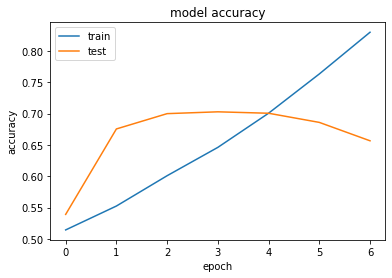

In [119]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['auroc'])
plt.plot(history.history['val_auroc']) 
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# New Section

In [179]:
score = model.evaluate([categories_one_hot_test,project_grade_category_test,state_one_hot_test,
                       teacher_prefix_test,sub_categories_one_hot_test,essay_padded_test,
                            numerical_test],y_test,batch_size=250)

36052/36052 [==============================] - 139s 4ms/sample - loss: 0.4529 - auroc: 0.6957


In [0]:
###Model 3

In [0]:
project_data_new=project_data

In [209]:
project_data_new.head(4)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1


In [210]:
project_data_new['project_subject_subcategories'] = project_data_new['project_subject_subcategories'].str.replace(' The ','')
project_data_new['project_subject_subcategories'] = project_data_new['project_subject_subcategories'].str.replace(' ','')
project_data_new['project_subject_subcategories'] = project_data_new['project_subject_subcategories'].str.replace('&','_')
project_data_new['project_subject_subcategories'] = project_data_new['project_subject_subcategories'].str.replace(',','_')
project_data_new['project_subject_subcategories'] = project_data_new['project_subject_subcategories'].str.lower()
len( project_data_new['project_subject_subcategories'].value_counts())


401

In [211]:
project_data_new['project_subject_categories'] = project_data_new['project_subject_categories'].str.replace(' The ','')
project_data_new['project_subject_categories'] = project_data_new['project_subject_categories'].str.replace(' ','')
project_data_new['project_subject_categories'] = project_data_new['project_subject_categories'].str.replace('&','_')
project_data_new['project_subject_categories'] = project_data_new['project_subject_categories'].str.replace(',','_')
project_data_new['project_subject_categories'] = project_data_new['project_subject_categories'].str.lower()
len(project_data_new['project_subject_categories'].value_counts())


51

In [0]:
# merge two column text dataframe: 
project_data_new["essay"] = project_data_new["project_essay_1"].map(str) +\
                        project_data_new["project_essay_2"].map(str) + \
                        project_data_new["project_essay_3"].map(str) + \
                        project_data_new["project_essay_4"].map(str)

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [214]:
sent = decontracted(project_data_new['essay'].values[20000])
print(sent)
print("="*50)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [215]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.     The materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   They also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. Phys

In [216]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations The materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills They also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is the

In [217]:
project_data_new['project_grade_category'] = project_data_new['project_grade_category'].str.replace(' ','_')
project_data_new['project_grade_category'] = project_data_new['project_grade_category'].str.replace('-','_')
project_data_new['project_grade_category'] = project_data_new['project_grade_category'].str.lower()
project_data_new['project_grade_category'].value_counts()

grades_prek_2    44225
grades_3_5       37137
grades_6_8       16923
grades_9_12      10963
Name: project_grade_category, dtype: int64

In [218]:
project_data_new['teacher_prefix'] = project_data_new['teacher_prefix'].str.replace('.','')
project_data_new['teacher_prefix'] = project_data_new['teacher_prefix'].str.lower()
project_data_new['teacher_prefix'].value_counts()

mrs        57269
ms         38955
mr         10648
teacher     2360
dr            13
Name: teacher_prefix, dtype: int64

In [219]:
project_data_new['school_state'] = project_data_new['school_state'].str.lower()
len(project_data_new['school_state'].value_counts())

51

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [221]:
from sklearn import model_selection
#x_bow=x_bow.tocsr()

y=project_data_new['project_is_approved']
X_1, X_test, y_1, y_test = model_selection.train_test_split(project_data_new, y, test_size=0.33, random_state=0,
                                                            stratify = project_data_new['project_is_approved'])
X_tr, X_cv, y_tr, y_cv = model_selection.train_test_split(X_1, y_1, test_size=0.33)
print(X_tr.shape, y_tr.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)
print("="*100)

(49041, 18) (49041,)
(24155, 18) (24155,)
(36052, 18) (36052,)


In [0]:
X_test.drop(['project_is_approved'],axis=1,inplace=True)
X_tr.drop(['project_is_approved'],axis=1,inplace=True)
X_cv.drop(["project_is_approved"],axis=1,inplace=True)

In [223]:
from tqdm import tqdm
tr_essay = []
# tqdm is for printing the status bar
for sentence in tqdm(X_tr['essay'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    tr_essay.append(sent.lower().strip())

100%|██████████| 49041/49041 [00:29<00:00, 1688.69it/s]


In [224]:
cv_essay = []
# tqdm is for printing the status bar
for sentence in tqdm(X_cv['essay'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = sent.lower().strip()
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    cv_essay.append(sent.lower().strip())

100%|██████████| 24155/24155 [00:14<00:00, 1719.56it/s]


In [225]:
test_essay_test = []
# tqdm is for printing the status bar
for sentence in tqdm(X_test['essay'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    test_essay_test.append(sent.lower().strip())

100%|██████████| 36052/36052 [00:21<00:00, 1696.23it/s]


In [0]:
X_tr['teacher_prefix']=X_tr['teacher_prefix'].fillna('mrs')
X_test['teacher_prefix']=X_test['teacher_prefix'].fillna('mrs')
X_cv['teacher_prefix']=X_cv['teacher_prefix'].fillna('mrs')

In [0]:
# we use count vectorizer to convert the values into one 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer=vectorizer.fit(X_tr['project_subject_categories'].values)
categories_one_hot_tr = vectorizer.transform(X_tr['project_subject_categories'].values)
categories_one_hot_cv = vectorizer.transform(X_cv['project_subject_categories'].values)

categories_one_hot_test = vectorizer.transform(X_test['project_subject_categories'].values)

In [0]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer=vectorizer.fit(X_tr['project_subject_subcategories'].values)
sub_categories_one_hot_tr = vectorizer.transform(X_tr['project_subject_subcategories'].values)
sub_categories_one_hot_cv = vectorizer.transform(X_cv['project_subject_subcategories'].values)
sub_categories_one_hot_test = vectorizer.transform(X_test['project_subject_subcategories'].values)

In [0]:
vectorizer =CountVectorizer(lowercase=False,binary=True)
vectorizer.fit(X_tr['school_state'].values)
state_one_hot_tr=vectorizer.transform(X_tr['school_state'].values)
state_one_hot_cv=vectorizer.transform(X_cv['school_state'].values)
state_one_hot_test=vectorizer.transform(X_test['school_state'].values)

In [0]:
vectorizer =CountVectorizer(lowercase=False,binary=True)
vectorizer.fit(X_tr['project_grade_category'].values)
project_grade_category_tr=vectorizer.transform(X_tr['project_grade_category'].values)
project_grade_category_cv=vectorizer.transform(X_cv['project_grade_category'].values)
project_grade_category_test=vectorizer.transform(X_test['project_grade_category'].values)

In [0]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
vectorizer.fit(X_tr['teacher_prefix'].values)
teacher_prefix_tr=vectorizer.transform(X_tr['teacher_prefix'].values)
teacher_prefix_cv=vectorizer.transform(X_cv['teacher_prefix'].values)
teacher_prefix_test=vectorizer.transform(X_test['teacher_prefix'].values)

In [0]:
from tensorflow.keras.preprocessing import sequence

In [0]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Input , Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import concatenate

In [233]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
#project_data = pd.merge(project_data, price_data, on='id', how='left')
X_tr=pd.merge(X_tr,price_data,on='id',how='left')
X_cv=pd.merge(X_cv,price_data,on='id',how='left')
X_test=pd.merge(X_test,price_data,on='id',how='left')
X_tr.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,essay,price,quantity
0,145908,p183089,3602831acbfaa81cc8fc7a574ee37fdb,ms,ny,2017-03-04 09:37:10,grades_prek_2,literacy_language_appliedlearning,literacy_parentinvolvement,Family Fun Tuesdays,"My students are enthusiastic kindergartners, f...",On designated Tuesdays all roads will lead par...,NaN,NaN,"My students need family engagement packs,sight...",10,"My students are enthusiastic kindergartners, f...",704.70,29
1,167161,p241842,16eb1ba4243d25702abe4ee2d223f4b2,ms,va,2017-02-21 12:37:34,grades_prek_2,math_science,appliedsciences_mathematics,Promoting STEM in the Summer for Underrepresen...,We are a transient Title 1 school in Virginia ...,Even though our new Summer Innovation Academy ...,NaN,NaN,My students need opportunities in the summer t...,6,We are a transient Title 1 school in Virginia ...,267.08,5
2,84801,p065667,f777bbaad382ef61a578ebf164f676d2,mrs,fl,2016-10-04 00:12:04,grades_prek_2,literacy_language,literature_writing,"Make it Fun, and they will Learn and Grow.",I want to provide my students with an educatio...,My students need some hands-on tools and activ...,NaN,NaN,"My students need age appropriate, differentiat...",0,I want to provide my students with an educatio...,219.88,14


In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_tr['price'].values.reshape(-1, 1))
price_normalized_tr=scaler.transform(X_tr['price'].values.reshape(-1, 1) )
price_normalized_cv=scaler.transform(X_cv['price'].values.reshape(-1, 1) )
price_normalized_test=scaler.transform(X_test['price'].values.reshape(-1, 1) )

In [0]:
scaler = StandardScaler()
scaler.fit(X_tr['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
teacher_prv_postprjct_normalise_tr=scaler.transform(X_tr['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1) )
teacher_prv_postprjct_normalise_cv=scaler.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1) )
teacher_prv_postprjct_normalise_test=scaler.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1) )

In [0]:
scaler = StandardScaler()
scaler.fit(X_tr['quantity'].values.reshape(-1, 1))
quantity_normalised_tr=scaler.transform(X_tr['quantity'].values.reshape(-1, 1) )
quantity_normalised_cv=scaler.transform(X_cv['quantity'].values.reshape(-1, 1) )
quantity_normalised_test=scaler.transform(X_test['quantity'].values.reshape(-1, 1) )

In [237]:
print(price_normalized_tr.shape)
print(price_normalized_test.shape)

print(teacher_prv_postprjct_normalise_test.shape)
print(teacher_prv_postprjct_normalise_tr.shape)

print(quantity_normalised_tr.T.shape)
print(quantity_normalised_test.shape)

(49041, 1)
(36052, 1)
(36052, 1)
(49041, 1)
(1, 49041)
(36052, 1)


In [238]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [239]:
from numpy import array
from numpy import asarray
from numpy import zeros
embeddings_index = dict()
f = open('/content/drive/My Drive/glove.6B.200d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [0]:
def padded(encoded_docs):  
    max_length = 350
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    return padded_docs

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(tr_essay)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs_tr = t.texts_to_sequences(tr_essay)
essay_padded_tr = padded(encoded_docs_tr)

In [0]:
encoded_docs_cv = t.texts_to_sequences(cv_essay)
essay_padded_cv = padded(encoded_docs_cv)

In [243]:
print(essay_padded_cv[0])

[   30     5   300   940  4934   135   135   233   356    36   147  5402
 24518  7408  1592   268  4934   355   498    26   356   147     1  1731
   669  6156     1   257   184   790    15 10601   267     2  1435    53
    41    12    60   286    93   463    31     1 10601   267     2   103
     2   317   252   208    81   822   363   578    96     2  2658     1
  4514   128  1902   208    82    60    48  1113     1  2835    82   182
    60     8 10906   882    98   300    59    98   117   853     1   303
   889   734   951   631    55   137    73   135 39159  5173  4934   355
  6067    29    59   230    48   810   928   418   850  2383  1068    40
     1   355   142     3  1181  1009  1484    12   273   516   553  3709
  1009  2684  6592   393    12   516   562    31     1    39   109     3
   778   727    39   700  1484   516   276     1     6   727   778 10002
 19422    80   109  1105   316     1    12    72   971   206    30     1
   614   516    12    28  1051  1198   516    39 22

In [0]:
encoded_docs_test = t.texts_to_sequences(test_essay_test)
essay_padded_test = padded(encoded_docs_test)

In [245]:
print(essay_padded_test[0])

[   1   17    2   37   15   84    6  845  186  135   81  122   44  124
    2  162    1  186    8  114    4  181   19  269   92    1   18 2859
 2274  843 2603  248    2  695  533  325  562   31  477    1  877  669
 2282  157 8898  184    3   72  132   38    1  178   21   91  808   48
  182   31    1 3587  168  470 1844   39 1231  292  182   31    4 2261
 1087  580    1   12   79   39    6  143  578  178  182   31    1    3
 1087   25   58   25   39  279   35   91 1335 1087  410 2138 1134  292
  459 1119  564  109 2439    1  332   10   58  185  999  580   12   79
 4069  307  304   27   39    9    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [246]:
print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 200))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.


In [0]:
from tensorflow.keras.layers import LSTM
text_1 = Input(shape=(350,))
embedding = Embedding(vocab_size, 200, input_length=350,weights=[embedding_matrix])(text_1)
embedding1=LSTM(64,recurrent_dropout=0.5,return_sequences=True)(embedding)
flatten_text_1 = Flatten()(embedding1)

In [248]:
flatten_text_1

<tf.Tensor 'flatten_12/Reshape:0' shape=(?, 22400) dtype=float32>

In [264]:
project_grade_category_tr.shape

(49041, 4)

(49041, 51)

In [0]:
from scipy.sparse import hstack

other_thentext_tr=hstack((price_normalized_tr,teacher_prv_postprjct_normalise_tr,quantity_normalised_tr,
                       categories_one_hot_tr,sub_categories_one_hot_tr,state_one_hot_tr,
                       project_grade_category_tr,teacher_prefix_tr))

In [0]:
other_thentext_cv=hstack((price_normalized_cv,teacher_prv_postprjct_normalise_cv,quantity_normalised_cv,
                       categories_one_hot_cv,sub_categories_one_hot_cv,state_one_hot_cv,
                       project_grade_category_cv,teacher_prefix_cv))

In [0]:
other_thentext_test=hstack((price_normalized_test,teacher_prv_postprjct_normalise_test,quantity_normalised_test,
                         categories_one_hot_test,sub_categories_one_hot_test,state_one_hot_test,
                       project_grade_category_test,teacher_prefix_test))

In [0]:
other_thentext_cv=other_thentext_cv.todense()
other_thentext_tr=other_thentext_tr.todense()
other_thentext_test=other_thentext_test.todense()

In [269]:
print(other_thentext_test.shape)

(36052, 494)


In [0]:
other_thentext_cv = np.array(other_thentext_cv).reshape(24155,494,1)
other_thentext_tr = np.array(other_thentext_tr).reshape(49041,494,1)
other_thentext_test = np.array(other_thentext_test).reshape(36052,494,1)


In [0]:
import tensorflow as tf
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.

config_proto = tf.ConfigProto()
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
session = tf.Session(config=config_proto)
set_session(session)

In [0]:
from tensorflow.keras.layers import Dense,concatenate,Activation,Dropout,Input,Conv1D
from tensorflow.keras.models import Model
other = Input(shape=(other_thentext_tr.shape[1],1),name="other")
conv1=Conv1D(64, 3, activation=tf.keras.layers.Activation('relu'))(other)
conv2=Conv1D(128, 3, activation=tf.keras.layers.Activation('relu'))(conv1)
flatten_1 = Flatten()(conv2)

In [61]:
flatten_1

<tf.Tensor 'flatten_1/Reshape:0' shape=(?, 62592) dtype=float32>

In [0]:
from tensorflow.keras.layers import concatenate
concat_layer=concatenate(inputs=[flatten_text_1,flatten_1],name="concat" )

In [0]:
from tensorflow.keras.layers import BatchNormalization

In [0]:
normalize=BatchNormalization()(concat_layer)

layer2 = Dense(units=64,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(),name="layer2")(normalize)
layer2 = Dropout(.65)(layer2)
normalize=BatchNormalization()(layer2)
layer3 = Dense(units=32,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(),name='layer3')(normalize)
layer3 = Dropout(.55)(layer3)
layer4 = Dense(units=16,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(),name="layer4")(layer3)
layer4 = Dropout(.55)(layer4)
output = Dense(1,activation='sigmoid',name="output")(layer4)

In [0]:
from tensorflow.keras.layers import Dense,concatenate,Activation,Dropout,Input
from tensorflow.keras.models import Model

In [0]:
model = Model(inputs=[text_1,other],outputs=output)

In [284]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
other (InputLayer)              [(None, 494, 1)]     0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 350, 200)     8250800     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 492, 64)      256         other[0][0]                      
____________________________________________________________________________________________

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=[auroc])

In [0]:
from keras.utils import to_categorical
y_binary_tr= to_categorical(y_tr)
y_binary_cv = to_categorical(y_cv)
y_binary_test = to_categorical(y_test)

In [289]:
history=model.fit([essay_padded_tr,other_thentext_tr],y_tr,batch_size=500,epochs=7,
                  validation_data=([essay_padded_cv,other_thentext_cv],y_cv))

Train on 49041 samples, validate on 24155 samples
Epoch 1/7
49041/49041 [==============================] - 621s 13ms/sample - loss: 2.3195 - auroc: 0.5212 - val_loss: 1.4801 - val_auroc: 0.5932
Epoch 2/7
49041/49041 [==============================] - 623s 13ms/sample - loss: 1.3087 - auroc: 0.5400 - val_loss: 1.0443 - val_auroc: 0.6059
Epoch 3/7
49041/49041 [==============================] - 640s 13ms/sample - loss: 0.9835 - auroc: 0.5746 - val_loss: 0.8350 - val_auroc: 0.6750
Epoch 4/7
49041/49041 [==============================] - 636s 13ms/sample - loss: 0.7894 - auroc: 0.6089 - val_loss: 0.6890 - val_auroc: 0.7143
Epoch 5/7
49041/49041 [==============================] - 644s 13ms/sample - loss: 0.6563 - auroc: 0.6461 - val_loss: 0.5973 - val_auroc: 0.7427
Epoch 6/7
49041/49041 [==============================] - 641s 13ms/sample - loss: 0.5852 - auroc: 0.6902 - val_loss: 0.5299 - val_auroc: 0.7517
Epoch 7/7
49041/49041 [==============================] - 645s 13ms/sample - loss: 0.52

dict_keys(['loss', 'auroc', 'val_loss', 'val_auroc'])


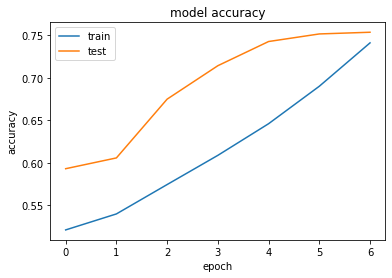

In [290]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['auroc'])
plt.plot(history.history['val_auroc']) 
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [291]:
score = model.evaluate([essay_padded_test,other_thentext_test],y_test,batch_size=500)

36052/36052 [==============================] - 105s 3ms/sample - loss: 0.5005 - auroc: 0.7575


In [181]:
from prettytable import PrettyTable
table=PrettyTable()
table.field_names=["model","train_auc","cv_auc","test_auc"]
table.add_row(["m_1","77.64","80.92","80.74"])
table.add_row(["m_2","69.86","70.22","69.57"])
table.add_row(["m_3","74.12","75.37","75.75"])

print(table)

+-------+-----------+--------+----------+
| model | train_auc | cv_auc | test_auc |
+-------+-----------+--------+----------+
|  m_1  |   77.64   | 80.92  |  80.74   |
|  m_2  |   69.86   | 70.22  |  69.57   |
|  m_3  |   74.12   | 75.37  |  75.75   |
+-------+-----------+--------+----------+
